In [10]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

# --- 1. CHARGEMENT ---
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
processed_path = PROJECT_ROOT / "data/processed"

df = pd.read_csv(processed_path / "cac40_final_superset.csv", parse_dates=['Date'])
clusters = pd.read_csv(processed_path / "clusters_mapping.csv")

# --- 2. NETTOYAGE CRITIQUE DU MAPPING ---
# Supprimer les espaces éventuels dans les noms de colonnes
clusters.columns = clusters.columns.str.strip()

# Si 'Ticker' est l'index, on le transforme en colonne
if 'Ticker' not in clusters.columns:
    clusters = clusters.reset_index()
    # On cherche une colonne qui contient "Ticker" ou "index"
    for col in clusters.columns:
        if "Ticker" in str(col) or "index" in str(col) or "Unnamed" in str(col):
            clusters = clusters.rename(columns={col: 'Ticker'})
            break

# On cherche la colonne des clusters (celle qui n'est pas Ticker)
potential_cols = [c for c in clusters.columns if c != 'Ticker']
if potential_cols:
    clusters = clusters.rename(columns={potential_cols[-1]: 'Cluster'})

# --- 3. FUSION ET VÉRIFICATION ---
# On fusionne avec 'how=inner' pour s'assurer de ne garder que les tickers présents dans les deux
df_with_clusters = pd.merge(df, clusters[['Ticker', 'Cluster']], on='Ticker', how='inner')

# SI L'ERREUR PERSISTE ICI, on affiche les colonnes pour diagnostiquer
if 'Cluster' not in df_with_clusters.columns:
    print("Colonnes détectées après fusion :", df_with_clusters.columns.tolist())
    # Force le nom sur la dernière colonne si nécessaire
    df_with_clusters.columns = [*df_with_clusters.columns[:-1], 'Cluster']

# --- 4. FILTRAGE ET PRÉDICTIONS ---
# Retrait des anomalies (Atos/Pernod Ricard à -1)
df_safe = df_with_clusters[df_with_clusters['Cluster'] != -1].copy()

model = joblib.load(PROJECT_ROOT / "models/random_forest_final.pkl")
latest_data = df_safe.sort_values('Date').groupby('Ticker').tail(1).copy()

# Utilisation des features exactes du modèle
features_cols = [c for c in latest_data.columns if c in model.feature_names_in_]
latest_data['Prob_Up'] = model.predict_proba(latest_data[features_cols])[:, 1]

# --- 5. OPTIMISATION ---
top_picks = latest_data[latest_data['Prob_Up'] > 0.51].sort_values(by='Prob_Up', ascending=False)

if not top_picks.empty:
    tickers_to_buy = top_picks['Ticker'].tolist()
    prices_df = df[df['Ticker'].isin(tickers_to_buy)].pivot(index='Date', columns='Ticker', values='Close').dropna()
    
    mu = expected_returns.mean_historical_return(prices_df)
    S = risk_models.sample_cov(prices_df)
    
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    print(f"\n✅ Portefeuille calculé sur {len(tickers_to_buy)} actions saines.")
    print("-" * 60)
    for ticker, weight in cleaned_weights.items():
        if weight > 0.001:
            p = top_picks[top_picks['Ticker'] == ticker]['Prob_Up'].values[0]
            c = top_picks[top_picks['Ticker'] == ticker]['Cluster'].values[0]
            print(f"{ticker:<10} | Poids: {weight*100:>6.2f}% | Confiance IA: {p*100:>5.2f}% | Clust: {int(c)}")
else:
    print("❌ Aucune action ne correspond aux critères.")

Colonnes détectées après fusion : ['Date', 'Ticker', 'Close', 'Volume', 'Returns', 'Volatility', 'Performance_20D', 'Sharpe_Ratio_20D', 'Dividends', 'Cluster_x', 'Target_Price', 'Target', 'Cluster_y']

✅ Portefeuille calculé sur 14 actions saines.
------------------------------------------------------------
HO.PA      | Poids:  38.06% | Confiance IA: 52.15% | Clust: 1
RMS.PA     | Poids:  61.94% | Confiance IA: 53.19% | Clust: 1


Backtest

🚀 Lancement du Backtest Walk-Forward...


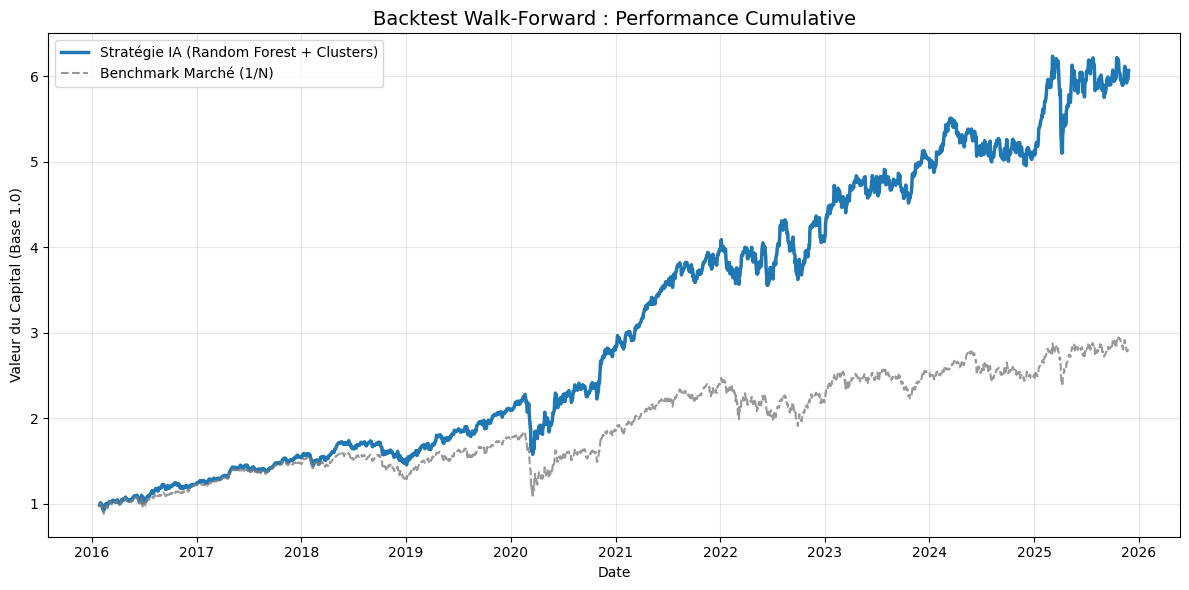

✅ RENDEMENT TOTAL IA      : 506.81%
📊 RENDEMENT TOTAL MARCHÉ  : 183.10%
🏆 ALPHA (SURPERFORMANCE) : 323.71%

       RAPPORT DE PERFORMANCE IA
📈 Rendement Global       :   506.81%
📅 Rendement Annualisé    :    20.13%
📉 Volatilité Annualisée  :    18.35%
💎 Ratio de Sharpe        :     0.99
⚠️ Maximum Drawdown       :   -30.71%


In [ ]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt

# Imports skfolio
from skfolio.optimization import RiskBudgeting, EqualWeighted
from skfolio.preprocessing import prices_to_returns
from skfolio.model_selection import WalkForward
from skfolio import RiskMeasure

# --- 1. CONFIGURATION ET CHARGEMENT ---
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
processed_path = PROJECT_ROOT / "data/processed"

df = pd.read_csv(processed_path / "cac40_final_superset.csv", parse_dates=['Date'])
clusters = pd.read_csv(processed_path / "clusters_mapping.csv")

# Nettoyage automatique du mapping
clusters.columns = clusters.columns.str.strip()
if 'Ticker' not in clusters.columns:
    clusters = clusters.reset_index().rename(columns={clusters.index.name: 'Ticker', 'Unnamed: 0': 'Ticker'})

# On identifie la colonne Cluster (la dernière) et on la renomme pour le modèle
col_cluster_source = [c for c in clusters.columns if c != 'Ticker'][-1]
clusters_clean = clusters[['Ticker', col_cluster_source]].rename(columns={col_cluster_source: 'Cluster'})

# --- 2. FUSION ET FILTRAGE DBSCAN ---
df_merged = pd.merge(df, clusters_clean, on='Ticker', how='inner')

# Gestion des suffixes si la colonne Cluster existait déjà
if 'Cluster_y' in df_merged.columns:
    df_merged = df_merged.drop(columns=['Cluster_x']).rename(columns={'Cluster_y': 'Cluster'})

# Sécurité : On retire le Cluster -1 (Atos, Pernod Ricard, etc.)
df_safe = df_merged[df_merged['Cluster'] != -1].copy()

# --- 3. GÉNÉRATION DES PRÉDICTIONS IA (RANDOM FOREST) ---
model = joblib.load(PROJECT_ROOT / "models/random_forest_final.pkl")
features_cols = [c for c in df_safe.columns if c in model.feature_names_in_]

# Le modèle a besoin de la colonne 'Cluster' car il a été entraîné avec
if 'Cluster' not in features_cols and 'Cluster' in model.feature_names_in_:
    features_cols.append('Cluster')

df_safe['Prob_Up'] = model.predict_proba(df_safe[features_cols])[:, 1]

# --- 4. PRÉPARATION DES DONNÉES POUR L'OPTIMISATION ---
all_prices = df_safe.pivot(index='Date', columns='Ticker', values='Close').ffill()
all_returns = prices_to_returns(all_prices)

# Masque de sélection : Top 10 actions recommandées par l'IA
prediction_series = df_safe.pivot(index='Date', columns='Ticker', values='Prob_Up').ffill()
selected_tickers_mask = (prediction_series.rank(axis=1, ascending=False) <= 10)

# --- 5. DÉFINITION DE L'OPTIMISEUR ROBUSTE ---
from skfolio.optimization import RiskBudgeting, EqualWeighted
from skfolio import RiskMeasure

# On utilise CVaR pour le risque et EqualWeighted comme secours si le solveur plante
optimizer = RiskBudgeting(
    risk_measure=RiskMeasure.CVAR,
    portfolio_params=dict(name="IA_Cluster_Portfolio"),
    fallback=EqualWeighted() 
)

# --- 6. BACKTESTING WALK-FORWARD ---
cv = WalkForward(train_size=252, test_size=60)
portfolio_results = []

print("🚀 Lancement du Backtest Walk-Forward...")

for train_idx, test_idx in cv.split(all_returns):
    last_train_date = all_returns.index[train_idx[-1]]
    
    # Sélection des 10 meilleurs tickers à cet instant T
    current_mask = selected_tickers_mask.loc[last_train_date]
    tickers_to_keep = current_mask[current_mask == True].index.tolist()
    
    # Nettoyage des données pour éviter les SolverError
    X_train = all_returns.iloc[train_idx][tickers_to_keep].dropna(axis=1, thresh=int(0.8*len(train_idx)))
    X_test = all_returns.iloc[test_idx][tickers_to_keep]
    
    common_tickers = X_train.columns.intersection(X_test.columns)
    
    if len(common_tickers) >= 2:
        X_final_train = X_train[common_tickers].fillna(0)
        X_final_test = X_test[common_tickers].fillna(0)
        
        try:
            optimizer.fit(X_final_train)
            p_test = optimizer.predict(X_final_test)
            portfolio_results.append(p_test)
        except Exception as e:
            print(f"⚠️ Période sautée à cause d'une erreur technique sur {last_train_date}")

# --- 7. AFFICHAGE DES RÉSULTATS ET GRAPHIQUE ---
if portfolio_results:
    # 1. Extraction et conversion en Series Pandas avec les dates
    ia_returns_list = []
    
    # On récupère les dates de test pour chaque fenêtre du Walk-Forward
    cv = WalkForward(train_size=252, test_size=60)
    test_indices = [test_idx for _, test_idx in cv.split(all_returns)]

    for i, p in enumerate(portfolio_results):
        # On récupère les dates correspondant à cette fenêtre de test
        dates = all_returns.index[test_indices[i]]
        
        # On crée une Series Pandas en s'assurant que la longueur correspond
        # p.returns est un ndarray, on lui attache ses dates
        s = pd.Series(p.returns.flatten(), index=dates)
        ia_returns_list.append(s)
    
    # Concaténation propre
    ia_returns = pd.concat(ia_returns_list)
    ia_returns = ia_returns.sort_index()
    
    # Calcul de la croissance cumulée
    ia_cum_growth = (1 + ia_returns).cumprod()

    # 2. Benchmark : Marché (1/N)
    bench_returns = all_returns.loc[ia_returns.index].mean(axis=1)
    bench_cum_growth = (1 + bench_returns).cumprod()

    # 3. Graphique
    plt.figure(figsize=(12, 6))
    plt.plot(ia_cum_growth, label='Stratégie IA (Random Forest + Clusters)', color='#1f77b4', lw=2.5)
    plt.plot(bench_cum_growth, label='Benchmark Marché (1/N)', color='#7f7f7f', linestyle='--', alpha=0.8)
    
    plt.title('Backtest Walk-Forward : Performance Cumulative', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Valeur du Capital (Base 1.0)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Bilan
    perf_ia = (ia_cum_growth.iloc[-1] - 1) * 100
    perf_bench = (bench_cum_growth.iloc[-1] - 1) * 100
    print(f"✅ RENDEMENT TOTAL IA      : {perf_ia:.2f}%")
    print(f"📊 RENDEMENT TOTAL MARCHÉ  : {perf_bench:.2f}%")
    print(f"🏆 ALPHA (SURPERFORMANCE) : {perf_ia - perf_bench:.2f}%")
else:
    print("❌ Aucun résultat généré.")


# 1. Rendement Annualisé (Compound Annual Growth Rate - CAGR)
days = (ia_returns.index[-1] - ia_returns.index[0]).days
years = days / 365.25
total_return = ia_cum_growth.iloc[-1]
cagr = (total_return ** (1/years)) - 1

# 2. Volatilité Annualisée
volatility = ia_returns.std() * np.sqrt(252)

# 3. Ratio de Sharpe (en supposant un taux sans risque à 2%)
risk_free_rate = 0.02
sharpe_ratio = (cagr - risk_free_rate) / volatility

# 4. Maximum Drawdown (La chute maximale entre un sommet et un creux)
roll_max = ia_cum_growth.cummax()
drawdown = (ia_cum_growth - roll_max) / roll_max
max_drawdown = drawdown.min()

# --- AFFICHAGE DU RAPPORT ---
print(f"\n" + "="*40)
print("       RAPPORT DE PERFORMANCE IA")
print("="*40)
print(f"📈 Rendement Global       : {(total_return - 1)*100:>8.2f}%")
print(f"📅 Rendement Annualisé    : {cagr*100:>8.2f}%")
print(f"📉 Volatilité Annualisée  : {volatility*100:>8.2f}%")
print(f"💎 Ratio de Sharpe        : {sharpe_ratio:>8.2f}")
print(f"⚠️ Maximum Drawdown       : {max_drawdown*100:>8.2f}%")
print("="*40)

In [24]:
# --- CONFIGURATION DU CAPITAL ---
CAPITAL_INITIAL = 10000  # Somme que tu souhaites investir aujourd'hui

# 1. Récupération des dernières prédictions et poids
# On utilise l'optimiseur entraîné sur les données les plus récentes
derniere_date = all_returns.index[-1]
current_mask = selected_tickers_mask.loc[derniere_date]
tickers_actifs = current_mask[current_mask == True].index.tolist()

# Calcul des poids optimaux actuels (Dernier Fit)
X_final = all_returns[tickers_actifs].tail(252).fillna(0)
optimizer.fit(X_final)
poids_finaux = optimizer.weights_ # Récupère les poids optimaux

# 2. Création du tableau récapitulatif
ticket_achat = pd.DataFrame({
    'Ticker': tickers_actifs,
    'Poids (%)': poids_finaux * 100
})

# 3. Calcul des montants et quantités
# On récupère le dernier prix de clôture pour chaque action
derniers_prix = df_safe[df_safe['Ticker'].isin(tickers_actifs)].groupby('Ticker')['Close'].last()
ticket_achat['Prix Unit (€)'] = ticket_achat['Ticker'].map(derniers_prix)
ticket_achat['Montant à Investir (€)'] = (ticket_achat['Poids (%)'] / 100) * CAPITAL_INITIAL
ticket_achat['Quantité d\'Actions'] = (ticket_achat['Montant à Investir (€)'] / ticket_achat['Prix Unit (€)']).apply(np.floor)

# --- AFFICHAGE DU TICKET D'ACHAT ---
print(f"\n🚀 TICKET D'EXÉCUTION - CAPITAL : {CAPITAL_INITIAL} €")
print("-" * 70)
print(ticket_achat[ticket_achat['Poids (%)'] > 0.1].sort_values('Poids (%)', ascending=False).to_string(index=False))
print("-" * 70)
print(f"💰 Cash restant (arrondis) : {CAPITAL_INITIAL - (ticket_achat['Quantité d\'Actions'] * ticket_achat['Prix Unit (€)']).sum():.2f} €")


🚀 TICKET D'EXÉCUTION - CAPITAL : 10000 €
----------------------------------------------------------------------
Ticker  Poids (%)  Prix Unit (€)  Montant à Investir (€)  Quantité d'Actions
 HO.PA  16.273433     231.100006             1627.343298                 7.0
 AI.PA  12.846332     158.600006             1284.633207                 8.0
SAN.PA  11.918191      83.320000             1191.819078                14.0
RMS.PA  10.457890    2134.000000             1045.788986                 0.0
 EL.PA   9.230761     282.100006              923.076100                 3.0
 LR.PA   9.082016     123.599998              908.201633                 7.0
SAF.PA   8.167187     291.299988              816.718720                 2.0
CAP.PA   7.478947     147.600006              747.894734                 5.0
 FR.PA   7.445460      11.470000              744.546009                64.0
VIV.PA   7.099782       2.356000              709.978234               301.0
----------------------------------------